# Clustering
After filtering down the data points and their attributes I had to split them into clusters based on their locations, not using any other attributes. Since the project's scope was to provide recommendations on city areas that a person might like based on their previous preferences, I had the following guidelines when choosing the clustering algorithm: 

* Clusters should be of the size of average walking distance for city strolls. It's another subjective metric I came up with which is equal to **1 kilometer maximum**
* Cluster density isn't that important compared to its size
* Minimum cluster size - **3 places**, which is also very subjective, but for me personally it's a bare minimum to consider area an area, not just a single place
* Number of clusters isn't important as well - which is a good reason to use unsupervised algorithms
* Needed to remove **outliers** - places which do not form a walkable cluster of minimum of 3 places.

To meet the guidelines before, I've started with **DBSCAN** to remove outliers first. Then I tried **MeanShift** - another density-based unsupervised algorithm. It didn't work because I couldn't achieve walkable cluster size. So after that I tried **K-Means** supervised clustering. K-Means allowed me to get smaller clusters than MeanShift, but it also created a lot of small clusters consisting of less than 3 points. Because of this, my production model became **Constrained K-Means** - the algorithm based on K-Means with functionality to limit the minimum and maximum number of points in a cluster.

In [114]:
# Libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd # geopandas to work with a GeoDataFrame
from shapely import wkt # for df -> gdf coordinates conversion

# Clustering 
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import KMeans 
from k_means_constrained import KMeansConstrained

In [104]:
# Data Import
df = pd.read_csv('../data/POIs_processed.csv', index_col = 'Unnamed: 0', low_memory=False) # importing csv as DataFrame

df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry']) # coordinates formatting to feed into GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

gdf.shape 

(5247, 295)

In [105]:
gdf.head()

,geometry,name,amenity,addr:street,drink:beer,drink:wine,drink:sake,drink:coffee,drink:tea,drink:espresso,...,omelette,pinsa,shawarma,garlic,waffle,napoletana,fried_cheese_sticks,modern,gyros,local
61670779,POINT (-122.43102 37.77214),Woods Lowside,pub,Haight Street,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61671096,POINT (-122.43122 37.77191),Toronado,pub,Haight Street,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61671382,POINT (-122.43176 37.77205),Molotov's,pub,Haight Street,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61672275,POINT (-122.43142 37.77189),Noc Noc,pub,Haight Street,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61673273,POINT (-122.43326 37.77186),Danny Coyles,pub,Haight Street,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


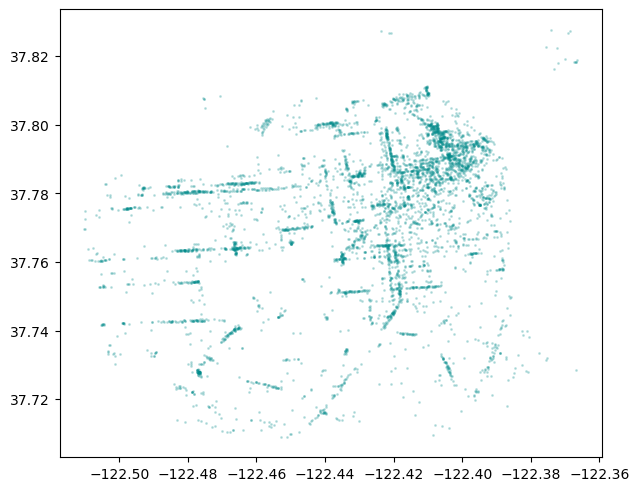

In [107]:
# Checking GeoDataFrame
gdf.plot(figsize = (7,7), color = 'darkcyan', marker = '.', markersize = 5, alpha = 0.2);

______
### Preprocessing: Reprojection from degrees to meters

Before clustering, I had to convert the data to be measured not in degrees, but in meters. For this I had to switch from WGS 84 to Web Mercator cartographic projection.

In [108]:
# Setting Initial Coordinate System to WGS84
gdf.set_crs('epsg:4326', inplace = True)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [109]:
# Converting places' coordinate system to Web Mercator so the distance is measured in meters which is more appropriate and intuitive for setting clustering search distance
gdf_webmer = gdf.to_crs(3857)
gdf_webmer.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [110]:
# Checking new format of coordinates
gdf_webmer = gdf_webmer[['geometry']]
gdf_webmer

,geometry
61670779,POINT (-13628958.280 4547287.332)
61671096,POINT (-13628981.279 4547254.265)
61671382,POINT (-13629041.447 4547274.587)
61672275,POINT (-13629003.242 4547251.322)
61673273,POINT (-13629208.560 4547247.886)
...,...
1105933644,POINT (-13625353.037 4548927.618)
1119498387,POINT (-13625162.909 4548103.080)
1119503897,POINT (-13627931.994 4548138.974)
1123730970,POINT (-13630542.200 4547147.945)


In [111]:
# Extracting x and y since they are the only values to be used when clustering points
gdf_webmer['x'] = gdf_webmer.geometry.x
gdf_webmer['y'] = gdf_webmer.geometry.y

gdf_webmer_cluster = gdf_webmer[['x', 'y']]

gdf_webmer_cluster

,x,y
61670779,-1.362896e+07,4.547287e+06
61671096,-1.362898e+07,4.547254e+06
61671382,-1.362904e+07,4.547275e+06
61672275,-1.362900e+07,4.547251e+06
61673273,-1.362921e+07,4.547248e+06
...,...,...
1105933644,-1.362535e+07,4.548928e+06
1119498387,-1.362516e+07,4.548103e+06
1119503897,-1.362793e+07,4.548139e+06
1123730970,-1.363054e+07,4.547148e+06


________________
### Clustering: DBSCAN to detect outliers
[DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) stands for Density-based spatial clustering of applications with noise. It's an unsupervised clustering algorithm which works best for clusters of consistent density. It creates clusters based on the given search distance, so they end up really big if there's not clear distinction between those. For this reason, it didn't suit project purpose, but it helped to filter out outliers - places that do not form a cluster of minimum of 3 points of interest.

In [112]:
dbscan = DBSCAN(eps=500, min_samples=3) # instantiating DBSCAN
dbscan.fit(gdf_webmer_cluster) # fitting data into it
set(dbscan.labels_) # checking output labels

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [113]:
# Saving labels to a dataframe
gdf_webmer_cluster['cluster'] = dbscan.labels_
gdf_webmer_cluster['not_cluster'] = gdf_webmer_cluster['cluster'].map(lambda x: 'outlier' if x == -1 else 'in cluster')

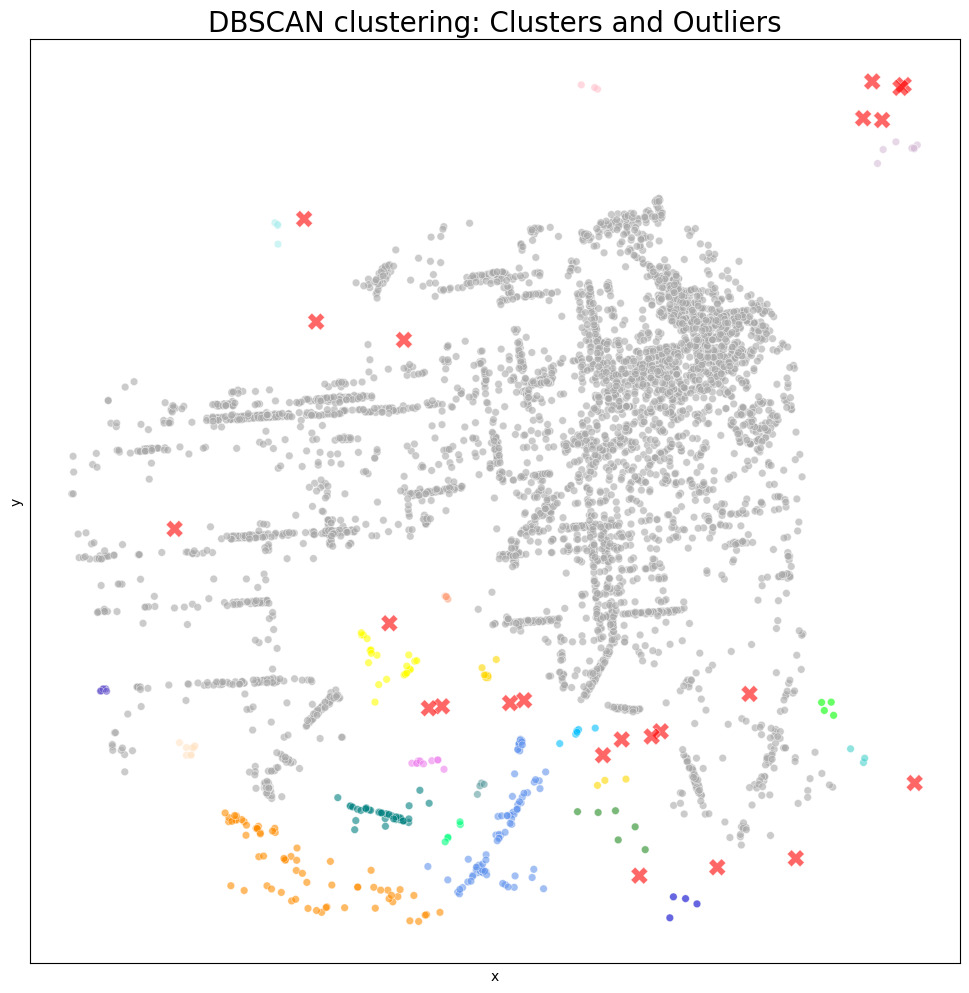

In [115]:
# Default color palettes were not very convenient to tell clusters apart, so I created a custom one
color_palette = {-1: 'red', 0: 'darkgrey', 1:'darkorange', 2: 'cornflowerblue', 3: 'forestgreen', 4:'gold', 5:'springgreen',
                6: 'bisque', 7: 'teal', 8: 'mediumblue', 9: 'yellow', 10: 'deepskyblue', 11: 'slateblue', 12:'violet', 13:'gold',
                14:'pink', 15:'lime', 16:'thistle', 17:'cadetblue', 18:'paleturquoise', 19:'lightsalmon', 20:'mediumturquoise'}

# Plotting clusters and noise
plt.figure(figsize = (12,12))

sns.scatterplot(
    data=gdf_webmer_cluster,
    x='x',
    y='y',
    hue = 'cluster',
    style = 'not_cluster',
    palette = color_palette,
    alpha = 0.6,
    size = 'not_cluster',
    sizes = [30,150],
    legend = False
);

plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False) # removing labels

plt.title('DBSCAN clustering: Clusters and Outliers', size = 20) # title

plt.savefig('../output/DBSACAN_outliers.png', dpi = 300, bbox_inches = 'tight'); # saving image

In [116]:
# Cluster sizes
gdf_webmer_cluster.cluster.value_counts()

 0     4920
 2       84
 1       66
 7       39
 9       26
-1       23
 12      10
 6        9
 16       8
 11       8
 4        8
 10       6
 3        6
 5        5
 8        4
 15       4
 17       4
 18       4
 19       4
 13       3
 14       3
 20       3
Name: cluster, dtype: int64

In [117]:
# Writing indexes of outliers into noise list
noise = gdf_webmer_cluster[gdf_webmer_cluster.cluster == -1].index
noise

Int64Index([1564470253, 5271201109, 6360940107, 6923605960, 8017457805,
            8828083318, 9606331425,   32777524,   34313521,  165420859,
             265868527,  271872797,  271914323,  273163284,  276779863,
             277889935,  289774621,  367586034,  430248354,  567269316,
             692740221,  698816546,  764313741],
           dtype='int64')

In [118]:
# Removing outliers from original and clustering dataframes
gdf_webmer = gdf_webmer.drop(index = noise)
gdf_webmer_cluster = gdf_webmer_cluster.drop(index = noise)
gdf = gdf.drop(index = noise)

DBSCAN helped me to detect and remove 23 points that didn't match 0.5 km threshold.

_______
### MeanShift 

[MeanShift](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html) is another unsupervised density-based algorithm which I thought might do a good job when dividing places into clusters of interest. 

In [120]:
# Converting dataframe to a numpy array so it can be used in MeanShift Clustering Algorithm
X = np.array(gdf_webmer_cluster[['x', 'y']])
X

array([[-13628958.28049949,   4547287.33226049],
       [-13628981.27910628,   4547254.26542606],
       [-13629041.44729106,   4547274.58715216],
       ...,
       [-13627931.9939938 ,   4548138.97414959],
       [-13630542.19999228,   4547147.94474105],
       [-13626413.4253251 ,   4549104.2946025 ]])

In [137]:
# Creating a function clustering points to figure out the minimum possible cluster size
def meanshift(bw):
    test_df = pd.DataFrame()
    '''
    Function to find minimum size of cluster based on different bandwidth 
    '''
    ms = MeanShift(bandwidth=bw, bin_seeding = True, min_bin_freq = 3)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    
    gdf_webmer_cluster['meanshift_labels'] = labels
    gdf_webmer_cluster['meanshift_labels']=gdf_webmer_cluster['meanshift_labels'].map(lambda x: str(x))
    
    distances = gdf_webmer_cluster.groupby('meanshift_labels').agg({'x': ['min', 'max'], 'y':['min', 'max']})
    distances.columns = ['x_min', 'x_max', 'y_min', 'y_max']
    distances['x_diff'] = distances['x_max'] - distances['x_min']
    distances['y_diff'] = distances['y_max'] - distances['y_min']
    
    print(f'bandwidth: {bw}, number of clusters: {n_clusters_}, max distance x, km: {distances.x_diff.max()/1000}, max distance y, km: {distances.y_diff.max()/1000}')

In [138]:
# Running function with different bandwidths
for i in range (50, 500, 50):
    meanshift(i)

bandwidth: 50, number of clusters: 259, max distance x, km: 5.047295768931508, max distance y, km: 3.841279635472223
bandwidth: 100, number of clusters: 357, max distance x, km: 2.5311714497059583, max distance y, km: 2.9519919014237823
bandwidth: 150, number of clusters: 303, max distance x, km: 2.5850978757161647, max distance y, km: 2.726951356918551
bandwidth: 200, number of clusters: 261, max distance x, km: 2.0488731347676366, max distance y, km: 2.989948624525219
bandwidth: 250, number of clusters: 196, max distance x, km: 1.962139748327434, max distance y, km: 2.989948624525219
bandwidth: 300, number of clusters: 173, max distance x, km: 2.5850978757161647, max distance y, km: 2.882248200713657
bandwidth: 350, number of clusters: 143, max distance x, km: 2.5690802471973, max distance y, km: 3.108257185076363
bandwidth: 400, number of clusters: 129, max distance x, km: 2.030499475089833, max distance y, km: 3.176632354042493
bandwidth: 450, number of clusters: 111, max distance 

In [125]:
# MeanShift with the smallest cluster size
ms = MeanShift(bandwidth=250, bin_seeding = True, min_bin_freq = 3)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 196


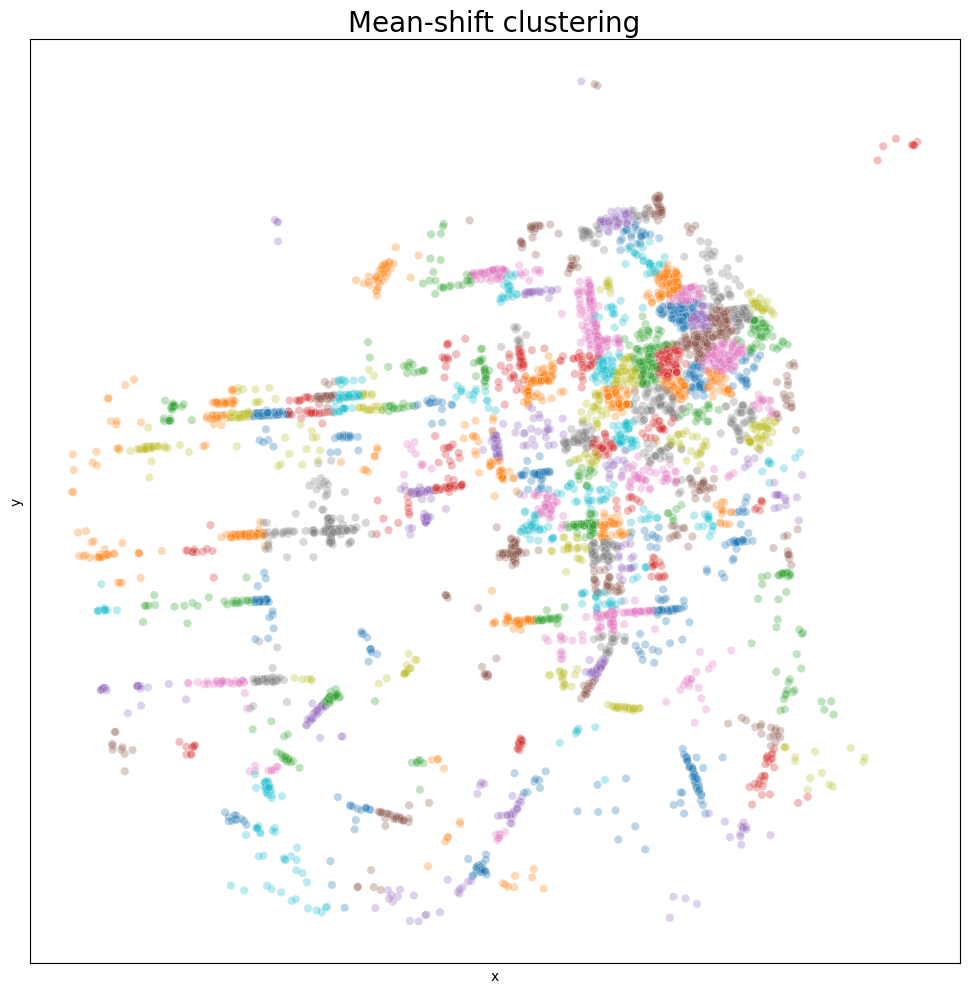

In [127]:
# Adding labels to a datframe
gdf_webmer_cluster['meanshift_labels'] = labels
gdf_webmer_cluster['meanshift_labels']=gdf_webmer_cluster['meanshift_labels'].map(lambda x: str(x))

# Visualising clusters
plt.figure(figsize = (12,12))
sns.scatterplot(
    data=gdf_webmer_cluster,
    x='x',
    y='y',
    hue = 'meanshift_labels',
    palette = 'tab10',
    legend = False,
    alpha = 0.3,
);

plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.title('Mean-shift clustering', size = 20);

In [128]:
# Cluster sizes
gdf_webmer_cluster.meanshift_labels.value_counts()

1      122
4      120
3      118
0      100
5       98
      ... 
184      5
182      4
185      4
190      4
193      4
Name: meanshift_labels, Length: 196, dtype: int64

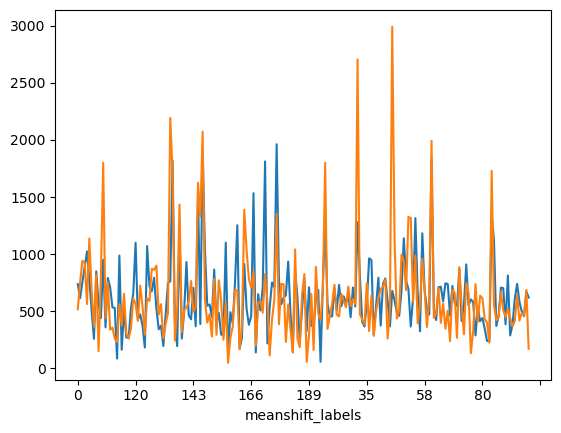

In [129]:
# Distances between points
distances = gdf_webmer_cluster.groupby('meanshift_labels').agg({'x': ['min', 'max'], 'y':['min', 'max']})

distances.columns = ['x_min', 'x_max', 'y_min', 'y_max']

distances['x_diff'] = distances['x_max'] - distances['x_min']
distances['y_diff'] = distances['y_max'] - distances['y_min']

distances.x_diff.plot();
distances.y_diff.plot();

In [130]:
distances.x_diff.max(), distances.y_diff.max()

(1962.139748327434, 2989.948624525219)

The clusters I got were too big, so I switched to supervised K-Means. Thanks to MeanShift, I knew an approximate range of cluster numbers to search through.

________
### K-means
[K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) computes clusters based on the number yof clusters set. I was able to use it because I beforehand removed outliers and got a good idea of clusters number. So to find an optimal value of clusters, I created a function and ran it for a range of values to narrow down the search.

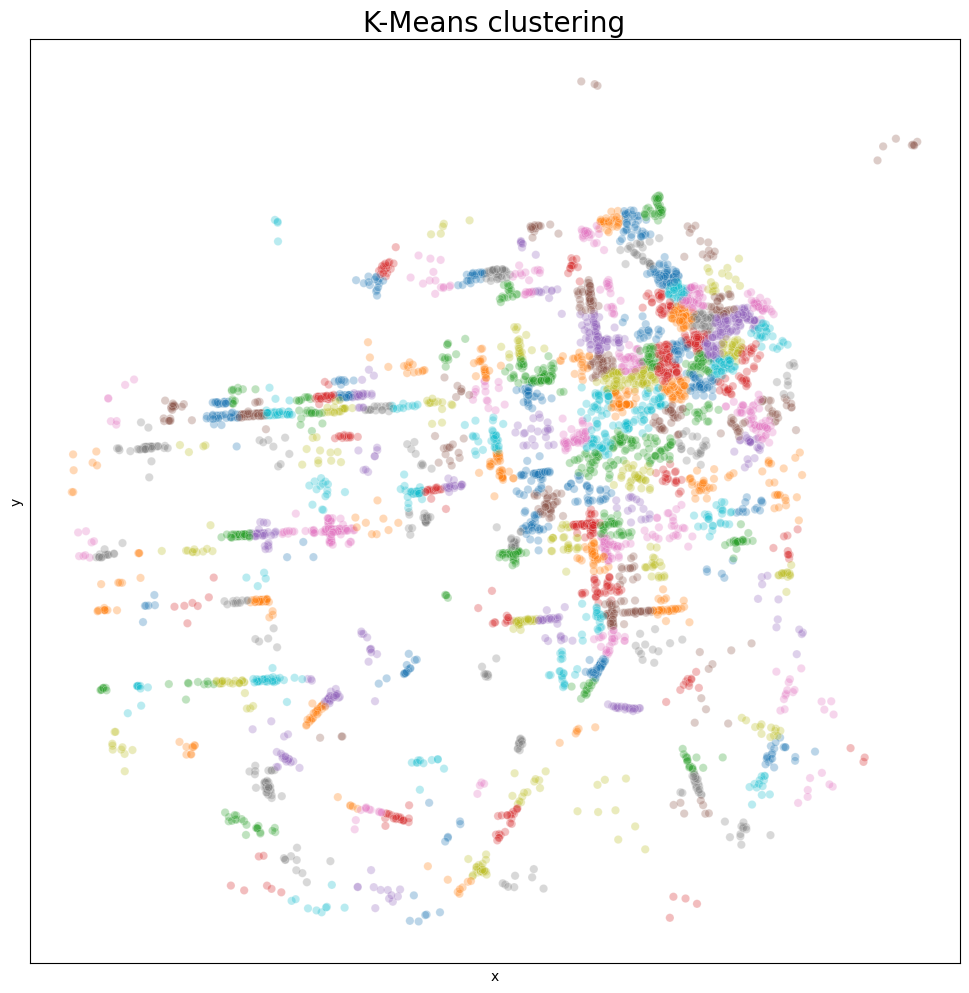

In [131]:
#K-Means instantiating and fit
kmeans = KMeans(n_clusters=224, n_init="auto", random_state = 42).fit(X)

# Adding labels to a dataframe
gdf_webmer_cluster['kmeans'] = kmeans.labels_
gdf_webmer_cluster['kmeans']=gdf_webmer_cluster['kmeans'].map(lambda x: str(x))

# Visualising results
plt.figure(figsize = (12,12))
sns.scatterplot(
    data=gdf_webmer_cluster,
    x='x',
    y='y',
    hue = 'kmeans',
    palette = 'tab10',
    legend = False,
    alpha = 0.3,
);

plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.title('K-Means clustering', size = 20);

plt.savefig('../output/K-Means.png', dpi = 300, bbox_inches = 'tight');

In [133]:
# Cluster sizes
gdf_webmer_cluster.kmeans.value_counts()

51     91
20     79
114    75
222    70
75     70
       ..
215     4
1       3
77      3
219     3
97      3
Name: kmeans, Length: 224, dtype: int64

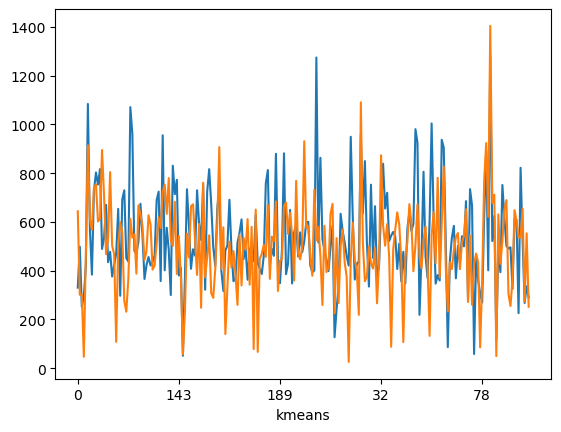

In [134]:
# Distance between points
distances = gdf_webmer_cluster.groupby('kmeans').agg({'x': ['min', 'max'], 'y':['min', 'max']})

distances.columns = ['x_min', 'x_max', 'y_min', 'y_max']

distances['x_diff'] = distances['x_max'] - distances['x_min']
distances['y_diff'] = distances['y_max'] - distances['y_min']

distances.x_diff.plot();
distances.y_diff.plot();

In [135]:
print(f'x max km: {round(distances.x_diff.max()/1000, 2)}, y max km: {round(distances.y_diff.max()/1000, 2)}')

x max km: 1.28, y max km: 1.4


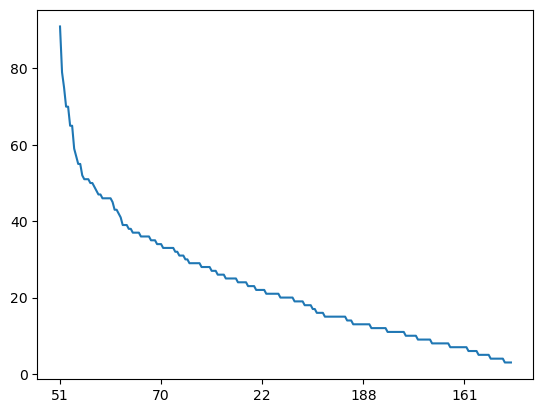

In [136]:
# Cluster size
gdf_webmer_cluster.kmeans.value_counts().plot();

In [139]:
def kmeans(clusters):
    '''
    Function to find the optimal clusters number to minimize cluster size
    '''
    kmeans = KMeans(n_clusters=clusters, n_init='auto', random_state = 42).fit(X)
    
    gdf_webmer_cluster['kmeans'] = kmeans.labels_
    gdf_webmer_cluster['kmeans']=gdf_webmer_cluster['kmeans'].map(lambda x: str(x))
    
    distances = gdf_webmer_cluster.groupby('kmeans').agg({'x': ['min', 'max'], 'y':['min', 'max']})
    distances.columns = ['x_min', 'x_max', 'y_min', 'y_max']
    distances['x_diff'] = distances['x_max'] - distances['x_min']
    distances['y_diff'] = distances['y_max'] - distances['y_min']
    
    print(f'clusters: {clusters}, min cluster size: {gdf_webmer_cluster.kmeans.value_counts()[-1]}, x max km: {round(distances.x_diff.max()/1000, 2)}, y max km: {round(distances.y_diff.max()/1000, 2)}')

In [141]:
# Running K-Means to find optimal cluster size
for i in range(100, 500, 20):
    kmeans(i)

clusters: 100, min cluster size: 3, x max km: 2.33, y max km: 1.79
clusters: 120, min cluster size: 3, x max km: 1.86, y max km: 1.63
clusters: 140, min cluster size: 3, x max km: 1.36, y max km: 1.43
clusters: 160, min cluster size: 3, x max km: 1.35, y max km: 1.43
clusters: 180, min cluster size: 3, x max km: 1.35, y max km: 1.43
clusters: 200, min cluster size: 3, x max km: 1.32, y max km: 1.4
clusters: 220, min cluster size: 3, x max km: 1.28, y max km: 1.4
clusters: 240, min cluster size: 3, x max km: 1.27, y max km: 1.09
clusters: 260, min cluster size: 3, x max km: 1.27, y max km: 1.09
clusters: 280, min cluster size: 2, x max km: 1.0, y max km: 0.91
clusters: 300, min cluster size: 1, x max km: 1.0, y max km: 0.91
clusters: 320, min cluster size: 1, x max km: 1.0, y max km: 0.91
clusters: 340, min cluster size: 1, x max km: 0.96, y max km: 0.92
clusters: 360, min cluster size: 1, x max km: 0.84, y max km: 0.92
clusters: 380, min cluster size: 1, x max km: 0.9, y max km: 0.91
c

K-Means didn't work well, because the minimum cluster that consisted of three points was too big for the project purpose. After doing some web search, I discovered Constrained K-Means, which seemed to be perfect because it allowed to restrict cluster size regarding the number of points.

________
### Constrained K-Means
> The algorithm is based on a paper by [Bradley et al.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-2000-65.pdf) and has been implemented by [Joshua Levy-Kramer](https://github.com/joshlk/k-means-constrained). 

It's based on classic K-Means but with an option to control minimum an maximum points number per cluster which made it a production algorithm for this project.

In [142]:
# Instantiating K-Means Constrained
clf = KMeansConstrained(
     n_clusters=300,
     size_min=3,
     size_max=30,
     random_state=42
)

# Fitting and clustering data
clf.fit_predict(X)

array([ 79,  79, 248, ...,  85, 214, 201], dtype=int32)

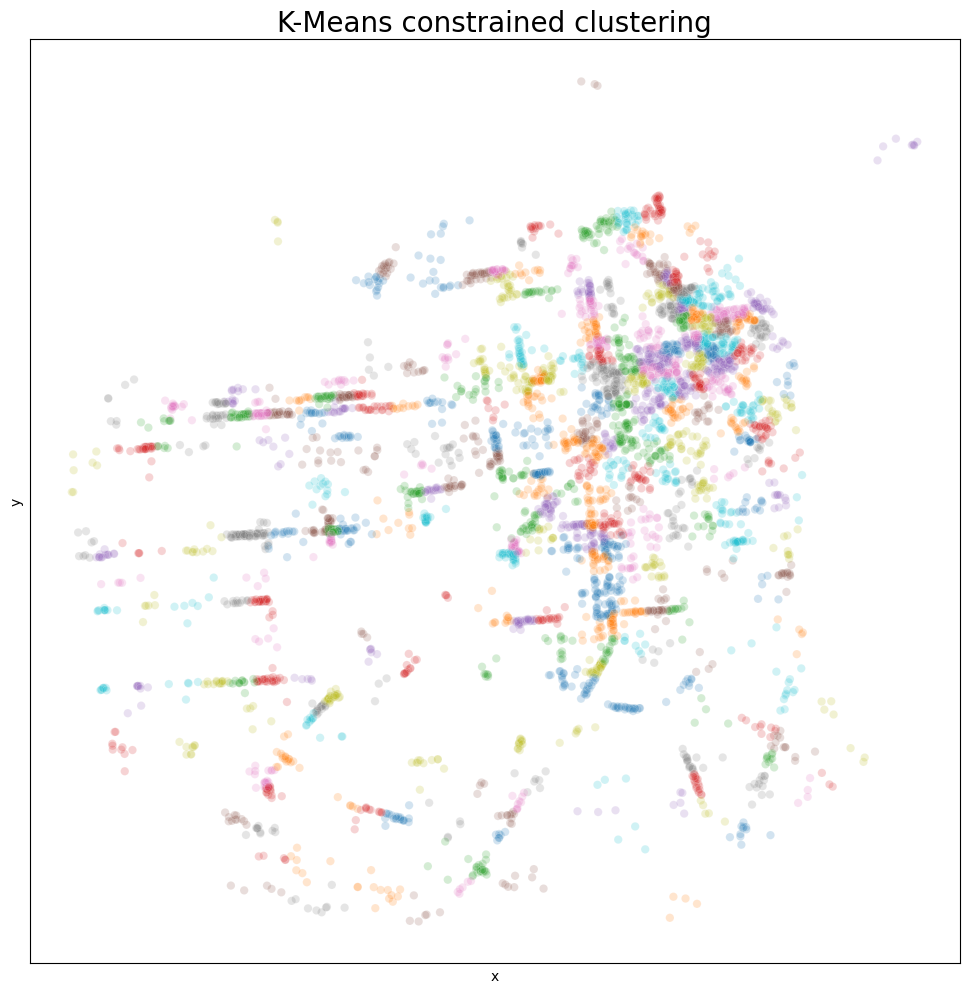

In [143]:
# Saving labels and centroids
gdf_webmer_cluster['kmeans_constrained'] = clf.labels_
gdf_webmer_cluster['kmeans_constrained']=gdf_webmer_cluster['kmeans_constrained'].map(lambda x: str(x))

kmeans_constrained_centers = pd.DataFrame(clf.cluster_centers_)
kmeans_constrained_centers.to_csv('../data/cluster_centers.csv')

# Vusualising clusters
plt.figure(figsize = (12,12))
sns.scatterplot(
    data=gdf_webmer_cluster,
    x='x',
    y='y',
    hue = 'kmeans_constrained',
    palette = 'tab10',
    legend = False,
    alpha = 0.2,
);

plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
plt.title('K-Means constrained clustering', size = 20);

plt.savefig('../output/K-Means-constrained.png', dpi = 300, bbox_inches = 'tight');

In [145]:
# Cluster sizes
gdf_webmer_cluster.kmeans_constrained.value_counts()

79     30
75     30
263    30
282    30
47     30
       ..
290     3
219     3
261     3
97      3
232     3
Name: kmeans_constrained, Length: 300, dtype: int64

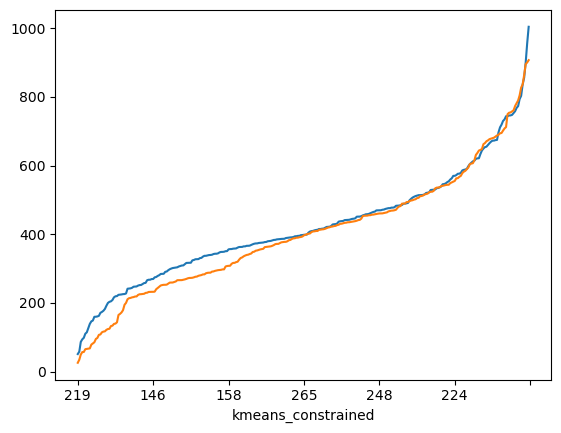

In [149]:
# Distance between points
distances = gdf_webmer_cluster.groupby('kmeans_constrained').agg({'x': ['min', 'max'], 'y':['min', 'max']})
distances.columns = ['x_min', 'x_max', 'y_min', 'y_max']
distances['x_diff'] = distances['x_max'] - distances['x_min']
distances['y_diff'] = distances['y_max'] - distances['y_min']
distances.x_diff.sort_values().plot();
distances.y_diff.sort_values().plot();

In [150]:
print(f'x max km: {round(distances.x_diff.max()/1000, 2)}, y max km: {round(distances.y_diff.max()/1000, 2)}')

x max km: 1.0, y max km: 0.91


In [151]:
# Adding cluster labels to dataframes
gdf['cluster'] = clf.labels_
gdf_webmer['cluster'] = clf.labels_

In [152]:
# Saving datasets updated with cluster information
gdf.to_csv('../data/POIs_clustered_4326.csv')
gdf_webmer.to_csv('../data/POIs_clustered_3857.csv')
distances.to_csv('../data/cluster_boundaries.csv')

_______
### Looking at clusters' extent

This section goes over plotting the biggest clusters on a map to make sure those qualify for somewhat walkability and enough density to form a potential area of interest.

In [154]:
# X
distances.sort_values(by = 'x_diff', ascending = False)[:7]

,x_min,x_max,y_min,y_max,x_diff,y_diff
kmeans_constrained,,,,,,
55,-1.363361e+07,-1.363261e+07,4.538578e+06,4.539122e+06,1003.745585,543.813172
274,-1.363476e+07,-1.363381e+07,4.538975e+06,4.539108e+06,955.210785,133.797577
154,-1.363136e+07,-1.363046e+07,4.550841e+06,4.551602e+06,898.838096,760.670928
280,-1.362529e+07,-1.362443e+07,4.543772e+06,4.544229e+06,855.456891,457.102631
6,-1.362454e+07,-1.362370e+07,4.541583e+06,4.542177e+06,835.630890,594.178185
106,-1.363236e+07,-1.363156e+07,4.538660e+06,4.539415e+06,802.597165,754.432793
299,-1.362973e+07,-1.362894e+07,4.545994e+06,4.546535e+06,793.307219,540.245308


In [157]:
# Y
distances.sort_values(by = 'y_diff', ascending = False)[:5]

,x_min,x_max,y_min,y_max,x_diff,y_diff
kmeans_constrained,,,,,,
161,-1.363583e+07,-1.363509e+07,4.544309e+06,4.545215e+06,743.402691,906.632540
181,-1.362405e+07,-1.362395e+07,4.546349e+06,4.547249e+06,98.484354,899.877067
109,-1.363709e+07,-1.363660e+07,4.548248e+06,4.549143e+06,489.053733,894.928797
131,-1.363405e+07,-1.363339e+07,4.545620e+06,4.546483e+06,660.020399,863.130546
102,-1.362444e+07,-1.362396e+07,4.542579e+06,4.543414e+06,471.215405,835.763438


In [156]:
# Importing TileMapBase to create quick static maps with OSM as a background
import tilemapbase
tilemapbase.start_logging()
tilemapbase.init(create=True)

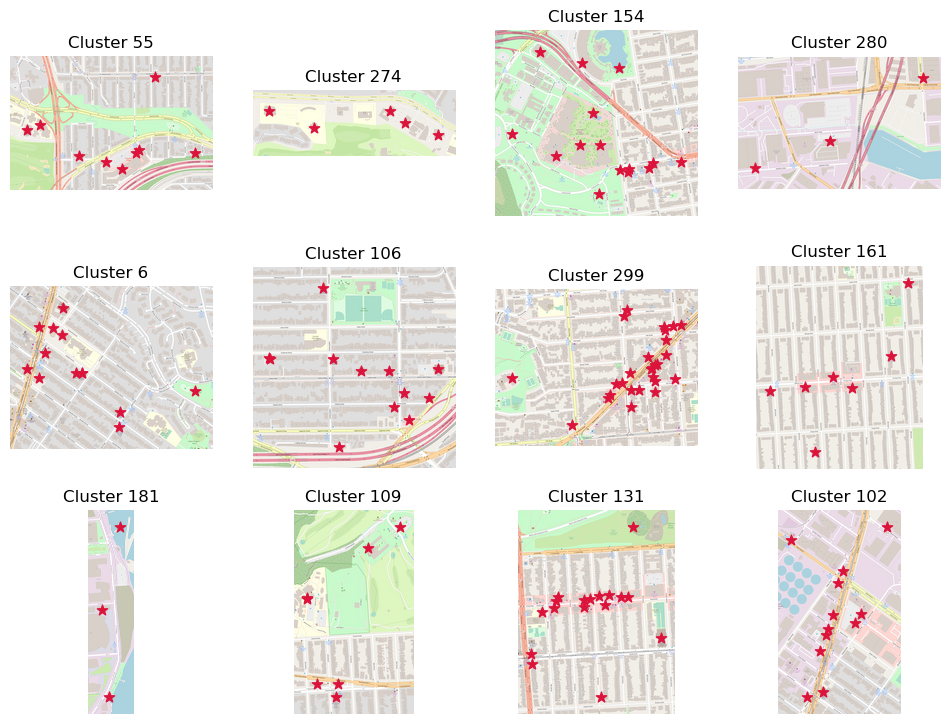

In [159]:
# Creating maps of clusters
plt.figure(figsize=(12, 9)) 

clusters = [55, 274, 154, 280, 6, 106, 299, 161, 181, 109, 131, 102] # biggest clusters from the queries abve

for pic in range(0,12): # loop to create 12 clusters' maps
    ax = plt.subplot(3, 4, pic + 1) 
    
    gdf_cluster = gdf_webmer.loc[gdf_webmer.cluster == clusters[pic]]
    extent = tilemapbase.extent_from_frame(gdf_cluster, buffer = 10)
    plotter = tilemapbase.Plotter(extent, tilemapbase.tiles.build_OSM(), width=1000, height = 1000)
    plotter.plot(ax)
    
    gdf_cluster.plot(ax=ax, color='crimson', markersize = 60, marker = "*")
    plt.title('Cluster ' + str(clusters[pic]))
    plt.axis('off')
    
plt.savefig('../output/biggest_clusters.png', dpi = 300, bbox_inches = 'tight');

To sum up, I used data filtered in a part 2 to create clusters of interest. Before clustering, I had to switch to meters for better interpretability and threshold settings. I first used DBSCAN to remove outliers, then tried 3 clustering techniques, and picked up production model which is Constrained K-Means. I ended up having 300 clusters of different sizes from 3 to 30 points, and this will be the basis for the Recommender System in the next section.